In [1]:
import numpy as np
import matplotlib.pyplot as plt

# add project root folder to path to allow import local modules
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
# import local modules
from helpers import compute_ridge_loss
from helpers import *
from implementations import *
from preprocessing import *

In [2]:
np.random.seed(2020)

## Make custom pipeline to create polynomial expansion of the features

In [3]:
class PolyPreprocessing(Preprocessing):
    def __init__(self,dataset):
        super().__init__(dataset)
        self.degree = None
        self.cross_degree = None
        
    def set_degrees(self,degree, cross_degree):
        self.degree = degree
        self.cross_degree = cross_degree
        
    def _feature_engineering(self):
        super()._feature_engineering() # to create pipeline
        
        dataset =self.dataset
        
        for deg in range(2,self.degree+1):
            self.dataset = np.concatenate((self.dataset, np.power(dataset,deg)),axis=1)
        
        if (self.cross_degree):
            for col_i in range(dataset.shape[1]):
                print(col_i)
                for col_j in range(col_i+1,dataset.shape[1]):
                    col = dataset[:,col_i]*dataset[:,col_j]
                    self.dataset = np.concatenate((self.dataset,col.reshape((-1,1))),axis=1)

     

## Prediction with decision boundary

In [4]:
def predict(weight, x_test, boundary = 0.5):
    """
    # Gives predictions given weight and datapoints 
    
    :param weight: vector weight
    :type weight: 1D array
    
    :param x_test: extended feature matrix
    :type x_test: 2D array
    
    :return: label predictions (0 or 1)
    :rtype:  1D numpy array
    
    """
    
    pred = x_test.dot(weight)
    return (pred > boundary)*1
    

##  Cross Validation

In [5]:
def build_k_indices(y, k_fold):
    """build k indices for k-fold."""
    num_row = y.shape[0]
    interval = int(num_row / k_fold)
    indices = np.random.permutation(num_row)
    k_indices = [indices[k * interval: (k + 1) * interval]
                 for k in range(k_fold)]
    return np.array(k_indices)

def K_Cross_Validation(x, y, K, _lambda):
    #Initialization of all needed arrays
    test_loss = np.zeros(K)
    train_loss = np.zeros(K)
    weights = np.zeros((K,x.shape[1]))
    accuracy = np.zeros(K)
    indices = build_k_indices(y, K)
    
    for i in range(K):
        test_indices = indices[i]
        y_test = y[test_indices]
        y_train = np.delete(y,test_indices)
        x_test = x[test_indices,:]
        x_train = np.delete(x,test_indices,axis=0)
        ### ADAPT METHOD & LOSS
        weights[i], train_loss[i] = ridge_regression(y_train, x_train,_lambda)
        test_loss[i] = compute_ridge_loss(y_test,x_test,weights[i],_lambda)
        
        #Calculate predictions of the model
        predictions = predict(weights[i] , x_test)
        #Calculate accuracy of the model
        accuracy[i] = np.sum(predictions == y_test) / len(y_test)
        
    return accuracy, test_loss, train_loss, np.mean(weights, axis=0)
        

## Determine degree

In [6]:
def PolyDegree(K, max_degree, lambda_):
        
    degrees = np.arange(3,max_degree)
    max_acc = 0
    min_loss = np.inf
    opt_degree = 0
    accuracies = []
    train_losses = []
    test_losses = []
    for i, degree in enumerate(degrees):
        # create train
        p_train = PolyPreprocessing(load_csv('../dataset/trainset.csv'))
        p_train.set_degrees(degree,0)
        y_train , x_train= p_train.preprocess()
        # K-cross validation
        accuracy,test,train,w = K_Cross_Validation(x_train, y_train, K,lambda_)
        accuracies.append([degree,np.mean(accuracy)])
        train_losses.append([degree,np.median(train)])
        test_losses.append([degree,np.median(test)])
        if (np.median(test) < min_loss):
            min_loss = np.median(test)
            max_acc = np.median(accuracy)
            opt_degree = degree
                
    return opt_degree , max_acc, np.array(accuracies), np.array(train_losses), np.array(test_losses)
opt_lambda, max_acc, acc ,train, test= PolyDegree(5,15, 0.00001)

print(f"optimal acc = {max_acc} with lambda= {opt_lambda}")

optimal acc = 0.7964666666666667 with lambda= 5


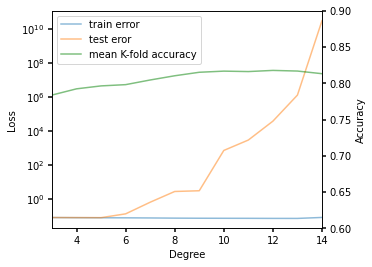

In [38]:
fig, host = plt.subplots()
fig.subplots_adjust(right=0.75)

par1 = host.twinx()


p1, = host.plot(train[:,0],train[:,1],alpha=0.5,label="train error")
p12, = host.plot(test[:,0],test[:,1],alpha=0.5, label = "test eror")
p2, = par1.plot(acc[:,0],acc[:,1], "g-",alpha=0.5,label="mean K-fold accuracy")


host.set_xlim(3, 14)
host.set_yscale('log')
par1.set_ylim(0.6, 0.9)

host.set_xlabel("Degree")
host.set_ylabel("Loss")
par1.set_ylabel("Accuracy")



tkw = dict(size=4, width=1.5)
host.tick_params(axis='y' , **tkw)
par1.tick_params(axis='y', **tkw)
host.tick_params(axis='x', **tkw)

lines = [p1,p12, p2]

host.legend(lines, [l.get_label() for l in lines])

plt.show();


In [8]:
acc

array([[ 3.        ,  0.78384444],
       [ 4.        ,  0.79242222],
       [ 5.        ,  0.79646667],
       [ 6.        ,  0.7982    ],
       [ 7.        ,  0.80462222],
       [ 8.        ,  0.81044444],
       [ 9.        ,  0.81526667],
       [10.        ,  0.81684444],
       [11.        ,  0.81624444],
       [12.        ,  0.81784444],
       [13.        ,  0.81695556],
       [14.        ,  0.81331111]])